### Importing libraries & data

In [11]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
import xgboost as xgb
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv('assignment-data.csv')
df.head(5)


,Unnamed: 0,datetime,load,apparent_temperature,temperature,humidity,dew_point,wind_speed,cloud_cover,date
0,0,2018-01-01 00:00:00,803.22270,10.45800,10.45800,0.955500,8.946000,0.0,0.0,2018-01-01
1,1,2018-01-01 00:15:00,774.89523,10.32675,10.32675,0.961625,8.911875,0.0,0.0,2018-01-01
2,2,2018-01-01 00:30:00,731.46927,10.19550,10.19550,0.967750,8.877750,0.0,0.0,2018-01-01
3,3,2018-01-01 00:45:00,713.93870,10.06425,10.06425,0.973875,8.843625,0.0,0.0,2018-01-01
4,4,2018-01-01 01:00:00,699.23007,9.93300,9.93300,0.980000,8.809500,0.0,0.0,2018-01-01


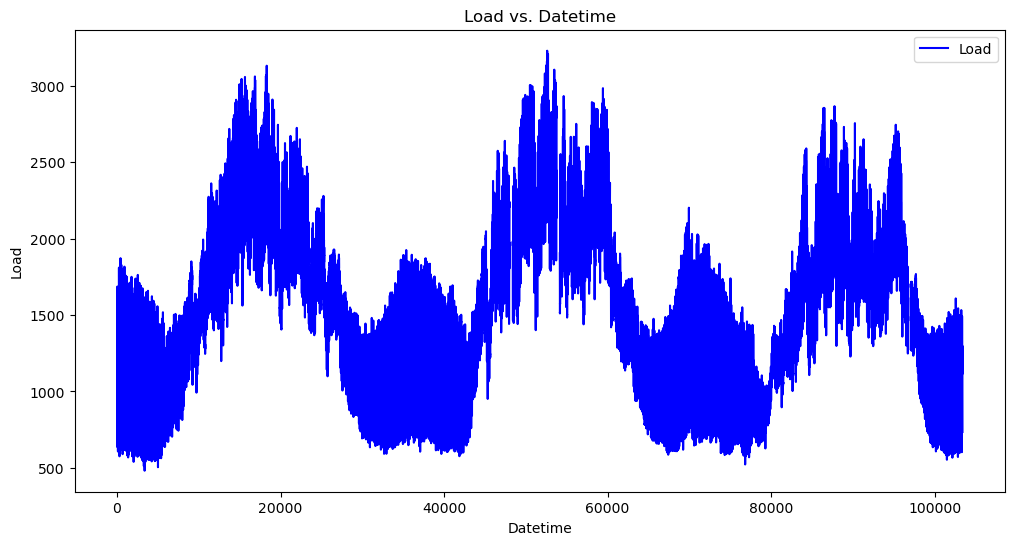

In [12]:
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['load'], color='blue', label='Load')
plt.title('Load vs. Datetime')
plt.xlabel('Datetime')
plt.ylabel('Load')
plt.legend()
plt.show()


## Task 2:Predicting Nan values of Load

#### ~The load column contains missing values in clustered sections.
#### ~Instead of dropping missing values which will cause not accurate model, a predictive model should be  trained to impute them using available features.
#### ~After getting full data that can be used to forecast for any date .

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103392 entries, 0 to 103391
Data columns (total 10 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Unnamed: 0            103392 non-null  int64  
 1   datetime              103392 non-null  object 
 2   load                  101952 non-null  float64
 3   apparent_temperature  103392 non-null  float64
 4   temperature           103392 non-null  float64
 5   humidity              103392 non-null  float64
 6   dew_point             103392 non-null  float64
 7   wind_speed            103392 non-null  float64
 8   cloud_cover           103392 non-null  float64
 9   date                  103392 non-null  object 
dtypes: float64(7), int64(1), object(2)
memory usage: 7.9+ MB


### Datetime column into datetime type and making it index

In [14]:
# Convert datetime column to datetime type
df['datetime'] = pd.to_datetime(df['datetime'])

df.set_index('datetime', inplace=True)

df = df.drop(columns=['Unnamed: 0','date'])
df['hour'] = df.index.hour
df['day'] = df.index.day
df['month'] = df.index.month
df['dayofweek'] = df.index.dayofweek
df['is_weekend'] = df['dayofweek'].isin([5, 6]).astype(int) 

print(df.isnull().sum())


load                    1440
apparent_temperature       0
temperature                0
humidity                   0
dew_point                  0
wind_speed                 0
cloud_cover                0
hour                       0
day                        0
month                      0
dayofweek                  0
is_weekend                 0
dtype: int64


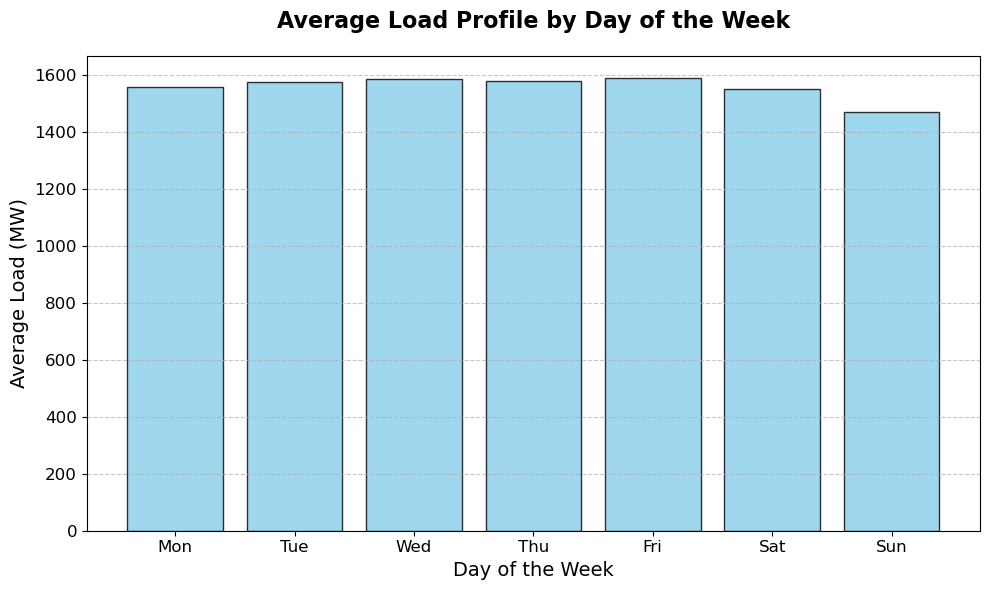

In [15]:
# Calculate the average load for each day of the week
daily_profile = df.groupby('dayofweek')['load'].mean()
plt.figure(figsize=(10, 6))
plt.bar(daily_profile.index, daily_profile.values, color='skyblue', edgecolor='black', alpha=0.8)
plt.title("Average Load Profile by Day of the Week", fontsize=16, fontweight='bold', pad=20)
plt.xlabel("Day of the Week", fontsize=14)
plt.ylabel("Average Load (MW)", fontsize=14)
plt.xticks(
    ticks=daily_profile.index, 
    labels=["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"], 
    fontsize=12
)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


### Splitting into train & test

In [16]:
train_df = df[df['load'].notna()]  # Rows with valid 'load' values
test_df = df[df['load'].isna()]  # Rows with NaN 'load' values

# Features (X) and target (y) for training
X_train = train_df.drop(columns=['load'])  
y_train = train_df['load']

X_test = test_df.drop(columns=['load'])

print(X_train.shape, y_train.shape, X_test.shape)


(101952, 11) (101952,) (1440, 11)


### Xgboost Regression to predict nan values of load & MAPE : 5.96% on training data

In [17]:


model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1)
model.fit(X_train, y_train)

# Predict missing 'load' values in the test set
predictions = model.predict(X_test)

# Evaluate model performance on the training set using MAPE
train_predictions = model.predict(X_train)
mape_train = mean_absolute_percentage_error(y_train, train_predictions) * 100  # Convert to percentage

print(f"MAPE on Training Data: {mape_train:.2f}%")


MAPE on Training Data: 5.96%


### Saving the predicted load values of laod 's nan values  in .csv 

0


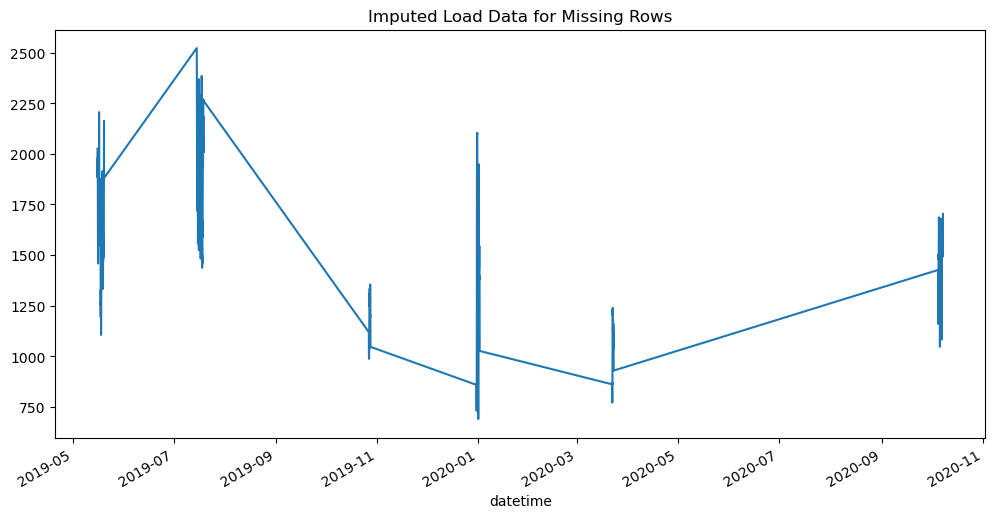

In [18]:
# Create a copy of the rows where 'load' is missing
imputed_df = test_df.copy()  # Copy the rows with missing 'load' values

# Impute the missing 'load' values with predictions
imputed_df['load'] = predictions  # Replace NaNs in 'load' with predicted values
print(imputed_df['load'].isna().sum()) 

# Save the imputed DataFrame to a new CSV file
imputed_df.to_csv('imputed_load_values.csv', index=False)
imputed_df['load'].plot(figsize=(12, 6))
plt.title('Imputed Load Data for Missing Rows')
plt.show()


### Imputing missing load values in original data to get full data 

In [19]:
# Impute the missing 'load' values in the original dataframe
df.loc[df['load'].isna(), 'load'] = predictions

# Check if all NaNs are filled
print(df['load'].isna().sum())



0


In [20]:
df.head(5)

,load,apparent_temperature,temperature,humidity,dew_point,wind_speed,cloud_cover,hour,day,month,dayofweek,is_weekend
datetime,,,,,,,,,,,,
2018-01-01 00:00:00,803.22270,10.45800,10.45800,0.955500,8.946000,0.0,0.0,0,1,1,0,0
2018-01-01 00:15:00,774.89523,10.32675,10.32675,0.961625,8.911875,0.0,0.0,0,1,1,0,0
2018-01-01 00:30:00,731.46927,10.19550,10.19550,0.967750,8.877750,0.0,0.0,0,1,1,0,0
2018-01-01 00:45:00,713.93870,10.06425,10.06425,0.973875,8.843625,0.0,0.0,0,1,1,0,0
2018-01-01 01:00:00,699.23007,9.93300,9.93300,0.980000,8.809500,0.0,0.0,1,1,1,0,0


# Task 1 :Short term forecast for the day 14 December 2020 in the frequency of 15  minutes

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 103392 entries, 2018-01-01 00:00:00 to 2020-12-12 23:45:00
Data columns (total 12 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   load                  103392 non-null  float64
 1   apparent_temperature  103392 non-null  float64
 2   temperature           103392 non-null  float64
 3   humidity              103392 non-null  float64
 4   dew_point             103392 non-null  float64
 5   wind_speed            103392 non-null  float64
 6   cloud_cover           103392 non-null  float64
 7   hour                  103392 non-null  int32  
 8   day                   103392 non-null  int32  
 9   month                 103392 non-null  int32  
 10  dayofweek             103392 non-null  int32  
 11  is_weekend            103392 non-null  int32  
dtypes: float64(7), int32(5)
memory usage: 8.3 MB


In [22]:
# Filter the data to only include up until 2020-12-12
train_data = df[:'2020-12-12 23:45:00']
train_data = train_data.dropna(subset=['load'])  


In [23]:
# Prepare the features and target variables
features = ['hour', 'day', 'month', 'dayofweek', 'is_weekend', 'apparent_temperature',
            'temperature', 'humidity', 'dew_point', 'wind_speed', 'cloud_cover']
X = train_data[features]  # Features
y = train_data['load']  # Target variable (load)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=False)

print(f"Training set size: {X_train.shape}, Test set size: {X_test.shape}")


Training set size: (93052, 11), Test set size: (10340, 11)


### stacking XGBoost WITH RandomForestRegressor 

In [24]:
from xgboost import XGBRegressor 

# estimators for stacking
estimators = [
    ('rf', RandomForestRegressor(n_estimators=100, max_depth=3)),
    ('xgb', XGBRegressor(objective='reg:squarederror'))  
]

stacking_model = StackingRegressor(estimators=estimators, final_estimator=Ridge())



In [25]:
stacking_model.fit(X_train, y_train)

StackingRegressor(estimators=[('rf', RandomForestRegressor(max_depth=3)),
                              ('xgb',
                               XGBRegressor(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rate=None, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=None,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=None, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, ...))],
                  final_estimator=Ridge())

### MAPE : 10.58%

In [26]:
train11_predictions11 = stacking_model.predict(X_train)
# Predict on the test set
test_predictions11=stacking_model.predict(X_test)

# Calculate MAPE (Mean Absolute Percentage Error)
mape = mean_absolute_percentage_error(y_test, test_predictions11)
print(f'MAPE on test set: {mape * 100:.2f}%')


MAPE on test set: 10.58%


### Grid Search CV

In [27]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 0.9, 1],
    'colsample_bytree': [0.7, 0.8, 1]
}

grid_search = GridSearchCV(estimator=xgb.XGBRegressor(objective='reg:squarederror'),
                           param_grid=param_grid, cv=3, n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)


Fitting 3 folds for each of 243 candidates, totalling 729 fits
Best Parameters: {'colsample_bytree': 0.7, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100, 'subsample': 0.9}


### MAPE : 9.45

In [28]:
train12_predictions12 = grid_search.predict(X_train)
test_predictions12=grid_search.predict(X_test)

# Calculate MAPE (Mean Absolute Percentage Error)
mape = mean_absolute_percentage_error(y_test, test_predictions12)
print(f'MAPE on test set: {mape * 100:.2f}%')


MAPE on test set: 9.45%


### XGBOOST

In [29]:
model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1)
model.fit(X_train, y_train)
train_predictions = model.predict(X_train)


### MAPE: 9.09

In [30]:
test_predictions = model.predict(X_test)

# Calculate MAPE (Mean Absolute Percentage Error)
mape = mean_absolute_percentage_error(y_test, test_predictions)
print(f'MAPE on test set: {mape * 100:.2f}%')


MAPE on test set: 9.09%


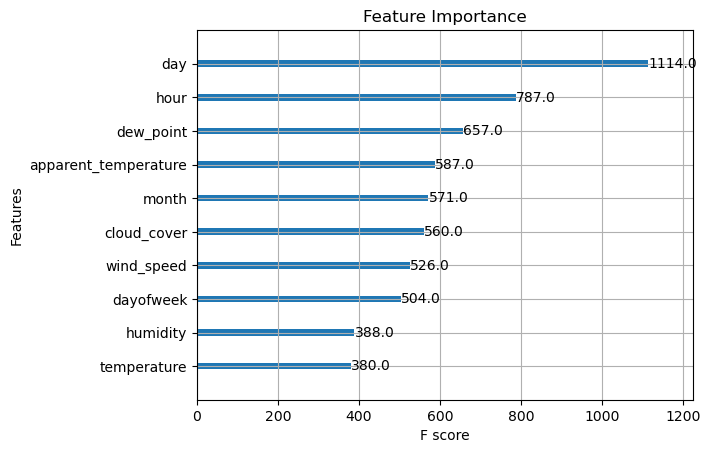

In [31]:
xgb_model = xgb.XGBRegressor(objective='reg:squarederror')
xgb_model.fit(X_train, y_train)

# Plot feature importance
xgb.plot_importance(xgb_model, importance_type='weight', max_num_features=10)
plt.title('Feature Importance')
plt.show()


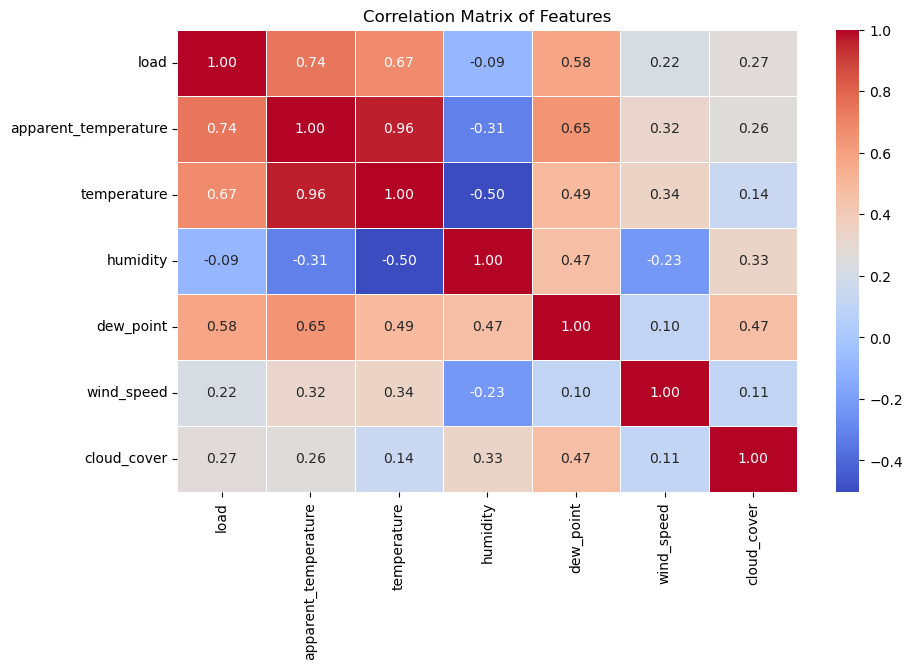

In [32]:
correlation_matrix = df[['load', 'apparent_temperature', 'temperature', 'humidity', 'dew_point', 'wind_speed', 'cloud_cover']].corr()

# Plot heatmap of correlation matrix
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix of Features')
plt.show()


## Will Use XGBOOST Moedl with MAPE: 9.08%

### Forecasting for the Date: 2020-12-14 in 15-minute interval

C:\Users\PC\AppData\Local\Temp\ipykernel_15356\1733619048.py:2: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  forecast_dates = pd.date_range(start='2020-12-14 00:00:00', periods=96, freq='15T')


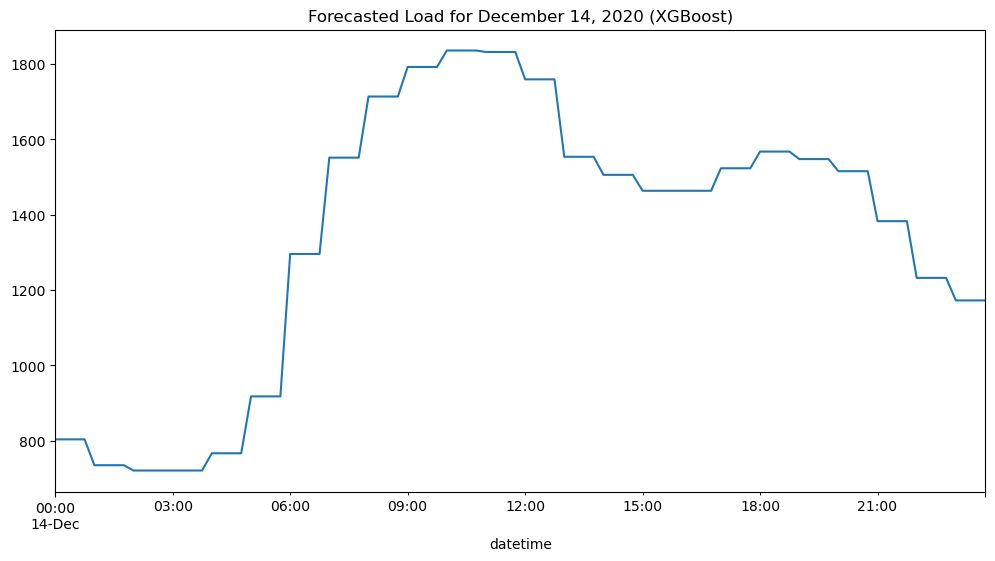

In [34]:
# Generate the date range for December 14, 2020 (96 intervals, 15-minute intervals)
forecast_dates = pd.date_range(start='2020-12-14 00:00:00', periods=96, freq='15T')

# Create features for the forecast date range
forecast_features = pd.DataFrame({
    'hour': forecast_dates.hour,
    'day': forecast_dates.day,
    'month': forecast_dates.month,
    'dayofweek': forecast_dates.dayofweek,
    'is_weekend': forecast_dates.dayofweek.isin([5, 6]).astype(int),
    'apparent_temperature': 0,  
    'temperature': 0,          
    'humidity': 0,             
    'dew_point': 0,            
    'wind_speed': 0,           
    'cloud_cover': 0           
})

# Predict the 'load' values for December 14, 2020
forecast_values = model.predict(forecast_features)

# Create a DataFrame for the forecasted results
forecast_df = pd.DataFrame({
    'datetime': forecast_dates,
    'forecast': forecast_values
})

# Save the forecasted values to a CSV file
forecast_df.to_csv('forecasted_load_dec14_xgboost_mape.csv', index=False)

forecast_df.set_index('datetime')['forecast'].plot(figsize=(12, 6))
plt.title('Forecasted Load for December 14, 2020 (XGBoost)')
plt.show()
